In [649]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import json
import re
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score

#from rdkit import Chem
#from rdkit.Chem import Descriptors
#from rdkit.Chem import rdMolDescriptors
import requests
import time

from bs4 import BeautifulSoup
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

In [650]:
ingredients_df = pd.read_csv('data/recipes.csv')
ingredients_df = pd.DataFrame(ingredients_df)

In [651]:
# Load the data
comp_path = 'data/flavor_network_data/ingr_comp/comp_info.tsv'
comp_tsv = pd.read_csv(comp_path, delimiter='\t')

comp_df = pd.DataFrame(data = comp_tsv)
comp_columns = ['compound_id', 'compound_name', 'CAS_number']
comp_df.columns = comp_columns

ingr_path = 'data/flavor_network_data/ingr_comp/ingr_info.tsv'
ingr_tsv = pd.read_csv(ingr_path, delimiter='\t')

ingr_df = pd.DataFrame(data = ingr_tsv)
ingr_columns = ['ingredient_id', 'ingredient_name', 'ingredient_category']
ingr_df.columns = ingr_columns

ingr_comp_pathh = 'data/flavor_network_data/ingr_comp/ingr_comp.tsv'
ingr_comp_tsv = pd.read_csv(ingr_comp_pathh, delimiter='\t')


In [652]:
ingr_comp_df = pd.DataFrame(data = ingr_comp_tsv)

In [653]:
ingr_comp_df.columns

Index(['# ingredient id', 'compound id'], dtype='object')

In [654]:
ingr_comp_df.rename(columns={
    '# ingredient id': 'ingredient_id',
    'compound id': 'compound_id'
}, inplace=True)

In [655]:
flav_edges_path = 'data/flavor_network_data/flavor_network_backbone/flavor_network_backbone_edges.tsv'
flav_edges_tsv = pd.read_csv(flav_edges_path, delimiter='\t')

flav_edges_df = pd.DataFrame(data = flav_edges_tsv)
flav_edges_columns = ['ingredient_1', 'ingredient_2', 'number_of_shared_compounds']
flav_edges_df.columns = flav_edges_columns

flav_nodes_path = 'data/flavor_network_data/flavor_network_backbone/flavor_network_backbone_nodes.tsv'
flav_nodes_tsv = pd.read_csv(flav_nodes_path, delimiter='\t')

flav_nodes_df = pd.DataFrame(data = flav_nodes_tsv)
flav_nodes_columns = ['ingredient_name', 'x_coordinate', 'y_coordinate', 'prevalence', 'r', 'g', 'b']
flav_nodes_df.columns = flav_nodes_columns

In [656]:
# Function to replace spaces with underscores
def replace_spaces(value):
    if isinstance(value, str):
        return value.replace(' ', '_')
    return value

In [657]:
ingr_df['ingredient_name'] = ingr_df['ingredient_name'].apply(replace_spaces)
ingr_df['ingredient_category'] = ingr_df['ingredient_category'].apply(replace_spaces)
flav_edges_df['ingredient_1'] = flav_edges_df['ingredient_1'].apply(replace_spaces)
flav_edges_df['ingredient_2'] = flav_edges_df['ingredient_2'].apply(replace_spaces)
flav_nodes_df['ingredient_name'] = flav_nodes_df['ingredient_name'].apply(replace_spaces)

In [658]:

data = {
    'Canada': 'NorthAmerican',
    'Turkey': 'MiddleEastern',
    'east_asian': 'EastAsian',
    'Caribbean': 'LatinAmerican',
    'Bangladesh': 'SouthAsian',
    'chinese': 'EastAsian',
    'mexico': 'LatinAmerican',
    'Lebanon': 'MiddleEastern',
    'japanese': 'EastAsian',
    'North-African': 'African',
    'MiddleEastern': 'MiddleEastern',
    'Indian': 'SouthAsian',
    'asian': 'EastAsian',
    'Italy': 'SouthernEuropean',
    'EasternEuropean_Russian': 'EasternEuropean',
    'Israel': 'MiddleEastern',
    'Korea': 'EastAsian',
    'Iran': 'MiddleEastern',
    'Eastern-Europe': 'EasternEuropean',
    'Jewish': 'MiddleEastern',
    'South-African': 'African',
    'Vietnamese': 'SoutheastAsian',
    'UK-and-Ireland': 'WesternEuropean',
    'French': 'WesternEuropean',
    'Mediterranean': 'SouthernEuropean',
    'Central_SouthAmerican': 'LatinAmerican',
    'Cajun_Creole': 'NorthAmerican',
    'Belgium': 'WesternEuropean',
    'China': 'EastAsian',
    'korean': 'EastAsian',
    'Germany': 'WesternEuropean',
    'South-America': 'LatinAmerican',
    'Spain': 'SouthernEuropean',
    'Netherlands': 'WesternEuropean',
    'Scandinavia': 'NorthernEuropean',
    'Philippines': 'SoutheastAsian',
    'Indonesia': 'SoutheastAsian',
    'East-African': 'African',
    'Scandinavian': 'NorthernEuropean',
    'Greek': 'SouthernEuropean',
    'American': 'NorthAmerican',
    'Vietnam': 'SoutheastAsian',
    'western': 'WesternEuropean',
    'African': 'African',
    'Switzerland': 'WesternEuropean',
    'West-African': 'African',
    'France': 'WesternEuropean',
    'Thai': 'SoutheastAsian',
    'Thailand': 'SoutheastAsian',
    'Italian': 'SouthernEuropean',
    'Pakistan': 'SouthAsian',
    'Irish': 'WesternEuropean',
    'Mexican': 'LatinAmerican',
    'Portugal': 'SouthernEuropean',
    'Chinese': 'EastAsian',
    'Mexico': 'LatinAmerican',
    'German': 'WesternEuropean',
    'Spanish_Portuguese': 'SouthernEuropean',
    'India': 'SouthAsian',
    'Japanese': 'EastAsian',
    'Moroccan': 'African',
    'Southern_SoulFood': 'NorthAmerican',
    'Malaysia': 'SoutheastAsian',
    'Austria': 'WesternEuropean',
    'English_Scottish': 'WesternEuropean',
    'Asian': 'EastAsian',
    'Southwestern': 'NorthAmerican',
    'Japan': 'EastAsian',
    'italian': 'SouthernEuropean',
    'canadian': 'NorthAmerican',
    'eastern_european_russian': 'EasternEuropean',
    'southern_soul_food': 'NorthAmerican',
    'middle_eastern': 'MiddleEastern',
    'central_south_american': 'LatinAmerican',
    'spanish': 'SouthernEuropean',
    'north_african': 'African',
    'portuguese': 'SouthernEuropean',
    'filipino': 'SoutheastAsian',
    'dutch': 'WesternEuropean',
    'iranian': 'MiddleEastern',
    'austrian': 'WesternEuropean',
    'swiss': 'WesternEuropean',
    'pakistani': 'SouthAsian',
    'malaysian': 'SoutheastAsian',
    'south_african': 'African',
    'west_african': 'African',
    'indonesian': 'SoutheastAsian',
    'belgian': 'WesternEuropean',
    'east_african': 'African',
    'israeli': 'MiddleEastern',
    'bangladeshi': 'SouthAsian'
}

mapping = pd.DataFrame(list(data.items()), columns=['country', 'region'])

# Clean the data
mapping['country'] = mapping['country'].str.strip()
mapping['region'] = mapping['region'].str.strip()

# Get unique regions and countries
unique_regions = mapping['region'].unique()
unique_countries = mapping['country'].unique()

regions_countries = mapping.groupby('region')['country'].apply(list).reset_index()






In [659]:
regions_countries.head(10)

,region,country
0,African,"[North-African, South-African, East-African, A..."
1,EastAsian,"[east_asian, chinese, japanese, asian, Korea, ..."
2,EasternEuropean,"[EasternEuropean_Russian, Eastern-Europe, east..."
3,LatinAmerican,"[Caribbean, mexico, Central_SouthAmerican, Sou..."
4,MiddleEastern,"[Turkey, Lebanon, MiddleEastern, Israel, Iran,..."
5,NorthAmerican,"[Canada, Cajun_Creole, American, Southern_Soul..."
6,NorthernEuropean,"[Scandinavia, Scandinavian]"
7,SouthAsian,"[Bangladesh, Indian, Pakistan, India, pakistan..."
8,SoutheastAsian,"[Vietnamese, Philippines, Indonesia, Vietnam, ..."
9,SouthernEuropean,"[Italy, Mediterranean, Spain, Greek, Italian, ..."


In [660]:
# Define the cuisine mapping with adjectival forms and variations
cuisine_mapping = {
    'vietnamese': ['vietnamese', 'vietnam'],
    'indian': ['indian', 'india'],
    'spanish_portuguese': ['spanish_portuguese'],
    'jewish': ['jewish'],
    'french': ['french', 'france'],
    'central_south_american': ['central_southamerican'],
    'cajun_creole': ['cajun_creole'],
    'thai': ['thai', 'thailand'],
    'scandinavian': ['scandinavian', 'scandinavia'],
    'greek': ['greek'],
    'american': ['american'],
    'african': ['african'],
    'middle_eastern': ['middleeastern', 'middle_eastern', 'turkey', 'iran', 'israel', 'lebanon'],
    'eastern_european_russian': ['easterneuropean_russian', 'eastern-europe', 'russia'],
    'italian': ['italian', 'italy'],
    'irish': ['irish', 'ireland'],
    'mexican': ['mexican', 'mexico'],
    'chinese': ['chinese', 'china'],
    'german': ['german', 'germany'],
    'mediterranean': ['mediterranean'],
    'japanese': ['japanese', 'japan'],
    'moroccan': ['moroccan'],
    'southern_soul_food': ['southern_soulfood'],
    'english_scottish': ['english_scottish', 'uk-and-ireland', 'england', 'scotland'],
    'asian': ['asian'],
    'southwestern': ['southwestern'],
    'east_asian': ['east_asian'],
    'western': ['western'],
    'korean': ['korean', 'korea'],
    'canadian': ['canada'],
    'caribbean': ['caribbean'],
    'bangladeshi': ['bangladesh'],
    'israeli': ['israel'],
    'iranian': ['iran'],
    'south_african': ['south-african'],
    'belgian': ['belgium'],
    'spanish': ['spain'],
    'dutch': ['netherlands'],
    'filipino': ['philippines'],
    'indonesian': ['indonesia'],
    'east_african': ['east-african'],
    'swiss': ['switzerland'],
    'west_african': ['west-african'],
    'north_african': ['north-african'],
    'pakistani': ['pakistan'],
    'portuguese': ['portugal'],
    'malaysian': ['malaysia'],
    'austrian': ['austria']
}

# Reverse the mapping for easier lookup
cuisine_lookup = {alias: cuisine for cuisine, aliases in cuisine_mapping.items() for alias in aliases}



# Create a dictionary from the mapping DataFrame
country_to_region = dict(zip(mapping['country'].str.lower().str.replace(' ', '_'), mapping['region'].str.lower().str.replace(' ', '_')))

# Explicitly format region names
def format_region_name(region):
    if pd.isna(region):
        return 'unknown'
    formatted_region = region.replace('southeastasian', 'south_east_asian') \
        .replace('southasian', 'south_asian') \
        .replace('southerneuropean', 'southern_european') \
        .replace('middleeastern', 'middle_eastern') \
        .replace('westerneuropean', 'western_european') \
        .replace('latinamerican', 'latin_american') \
        .replace('northamerican', 'north_american') \
        .replace('northerneuropean', 'northern_european') \
        .replace('easterneuropean', 'eastern_european') \
        .replace('eastasian', 'east_asian')
    return formatted_region

# Function to standardize country names and map to region
def standardize_and_map_region(country):
    if pd.isna(country):
        return 'unknown', 'unknown'
    country_lower = str(country).lower().replace(' ', '_')
    standardized_country = cuisine_lookup.get(country_lower, country_lower)
    region = country_to_region.get(standardized_country, 'unknown')
    return standardized_country, format_region_name(region)


# Apply the function to create new columns
ingredients_df[['country', 'region']] = ingredients_df['country'].apply(lambda x: pd.Series(standardize_and_map_region(x)))

# Move the 'region' column to the beginning
columns = ['region'] + [col for col in ingredients_df if col != 'region']
ingredients_df = ingredients_df[columns]


In [661]:
ingredients_df.replace({'Yes': 1, 'No': 0}, inplace=True)

In [662]:
ingr_small = ingredients_df.columns.copy()

In [663]:
ingr_small = pd.DataFrame(data=ingr_small)

In [664]:
# Assign column names if necessary
ingr_small.columns = ['ingredient_name']

# Drop rows that contain 'region' or 'country'
ingr_small = ingr_small[~ingr_small['ingredient_name'].isin(['region', 'country'])]

# Add ingredient_id column
ingr_small.insert(0, 'ingredient_id', range(1, 1 + len(ingr_small)))

# Print the cleaned DataFrame
print(ingr_small)

     ingredient_id ingredient_name
2                1          almond
3                2        angelica
4                3           anise
5                4      anise_seed
6                5           apple
..             ...             ...
380            379            wood
381            380             yam
382            381           yeast
383            382          yogurt
384            383        zucchini

[383 rows x 2 columns]


In [665]:
ingr_small['ingredient_name'] = ingr_small['ingredient_name'].apply(replace_spaces)

In [666]:
# Function to replace ingredient IDs
def replace_ingredient_id(ingr_small, ingr_df):
    # Create a dictionary for quick lookup of ingredient_id by ingredient_name
    ingr_dict = pd.Series(ingr_df.ingredient_id.values, index=ingr_df.ingredient_name).to_dict()

    # Function to replace ingredient_id if ingredient_name matches
    def replace_id(row):
        ingredient_name = row['ingredient_name']
        if ingredient_name in ingr_dict:
            row['ingredient_id'] = ingr_dict[ingredient_name]
        return row

    # Apply the function to each row in ingr_small
    ingr_small = ingr_small.apply(replace_id, axis=1)

    return ingr_small

# Apply the function
ingr_small = replace_ingredient_id(ingr_small, ingr_df)

# Verify the changes
print(ingr_small.head())

   ingredient_id ingredient_name
2             18          almond
3            725        angelica
4            707           anise
5            395      anise_seed
6           1197           apple


In [667]:
ingr_small_def = ingr_small.copy()

In [668]:
comp_df

,compound_id,compound_name,CAS_number
0,0,jasmone,488-10-8
1,1,5-methylhexanoic_acid,628-46-6
2,2,l-glutamine,56-85-9
3,3,1-methyl-3-methoxy-4-isopropylbenzene,1076-56-8
4,4,methyl-3-phenylpropionate,103-25-3
...,...,...,...
1102,1102,2-heptanol,543-49-7
1103,1103,1-octen-3-yl_butyrate,16491-54-6
1104,1104,guaiacol,90-05-1
1105,1105,(+/?)-methyl_5-acetoxyhexanoate,35234-22-1


In [669]:
ingr_comp_merge = ingr_comp_df.copy()

In [670]:
ingr_comp_merge.compound_id = ingr_comp_merge.compound_id.astype(str)

In [671]:
ingr_small['ingredient_id'] = ingr_small['ingredient_id'].astype(str)
ingr_comp_df['ingredient_id'] = ingr_comp_df['ingredient_id'].astype(str)
ingr_comp_df['compound_id'] = ingr_comp_df['compound_id'].astype(str)

# Convert column names in ingr_small to strings
ingr_small.columns = ingr_small.columns.astype(str)

# Get the unique compound_ids in ingr_comp_df
compound_id_list = ingr_comp_df['compound_id'].unique()

# Create a DataFrame to hold the new columns with initial values set to 0
new_columns_df = pd.DataFrame(0, index=ingr_small.index, columns=compound_id_list)

# Concatenate the new columns to ingr_small
ingr_small = pd.concat([ingr_small, new_columns_df], axis=1)

# Iterate through ingr_comp_df and update the values in ingr_small
for index, row in ingr_comp_df.iterrows():
    ingredient_id = row['ingredient_id']
    compound_id = row['compound_id']
    if ingredient_id in ingr_small['ingredient_id'].values:
        ingr_small.loc[ingr_small['ingredient_id'] == ingredient_id, compound_id] = 1

# Verify the result
print(ingr_small.head())

  ingredient_id ingredient_name  906  861  673  278  171  387  165  1099  ...   
2            18          almond    0    0    0    0    0    0    0     0  ...  \
3           725        angelica    0    0    1    0    0    0    0     0  ...   
4           707           anise    0    0    1    0    0    0    1     0  ...   
5           395      anise_seed    0    0    0    0    0    0    0     0  ...   
6          1197           apple    0    0    0    1    0    0    0     0  ...   

   722  237  169  23  310  653  966  752  497  754  
2    0    0    0   0    0    0    0    0    0    0  
3    0    0    0   0    0    0    0    0    0    0  
4    0    0    0   0    0    0    0    0    0    0  
5    0    0    0   0    0    0    0    0    0    0  
6    0    0    0   0    0    0    0    0    0    0  

[5 rows x 1109 columns]


In [672]:
ingr_small.shape

(383, 1109)

In [673]:
compound_id_cols = [col for col in ingr_small.columns if col not in ['ingredient_id', 'ingredient_name']]

In [674]:
ingr_small['count_ones'] = ingr_small[compound_id_cols].sum(axis=1)

In [675]:
ingr_comp_df

,ingredient_id,compound_id
0,1392,906
1,1259,861
2,1079,673
3,22,906
4,103,906
...,...,...
36776,876,657
36777,637,461
36778,689,650
36779,689,297


In [676]:
# Group by 'ingredient_id' and aggregate 'compound_id' into a list
comp_per_ingr = ingr_comp_df.groupby('ingredient_id')['compound_id'].apply(list).reset_index()
ingr_per_comp = ingr_comp_df.groupby('compound_id')['ingredient_id'].apply(list).reset_index()

In [677]:
ingr_per_comp.sort_values(by='compound_id', ascending=False, inplace=True)

In [678]:
print(ingr_comp_df.compound_id.unique())

['906' '861' '673' ... '752' '497' '754']


In [679]:
ingr_per_comp.shape

(1107, 2)

In [680]:
comp_per_ingr

,ingredient_id,compound_id
0,0,[995]
1,1,[921]
2,10,[715]
3,100,[1011]
4,1000,"[764, 275, 630, 1046, 285, 84, 482, 772, 686, ..."
...,...,...
1520,995,[996]
1521,996,[894]
1522,997,[828]
1523,998,"[25, 317, 86]"


In [681]:
ingr_small

,ingredient_id,ingredient_name,906,861,673,278,171,387,165,1099,...,237,169,23,310,653,966,752,497,754,count_ones
2,18,almond,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
3,725,angelica,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,707,anise,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,17
5,395,anise_seed,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
6,1197,apple,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1396,wood,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
381,705,yam,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
382,407,yeast,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3
383,230,yogurt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,37


In [682]:
ingr_small['ingredient_name'] = ingr_small['ingredient_name'].astype(str)

In [683]:
ingredient_cols = ingredients_df.columns.copy()

In [684]:
ingredient_cols

Index(['region', 'country', 'almond', 'angelica', 'anise', 'anise_seed',
       'apple', 'apple_brandy', 'apricot', 'armagnac',
       ...
       'whiskey', 'white_bread', 'white_wine', 'whole_grain_wheat_flour',
       'wine', 'wood', 'yam', 'yeast', 'yogurt', 'zucchini'],
      dtype='object', length=385)

In [685]:
ingr_small

,ingredient_id,ingredient_name,906,861,673,278,171,387,165,1099,...,237,169,23,310,653,966,752,497,754,count_ones
2,18,almond,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
3,725,angelica,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,707,anise,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,17
5,395,anise_seed,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
6,1197,apple,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1396,wood,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
381,705,yam,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
382,407,yeast,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3
383,230,yogurt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,37


In [686]:
ingr_small["ingredient_name"]

2          almond
3        angelica
4           anise
5      anise_seed
6           apple
          ...    
380          wood
381           yam
382         yeast
383        yogurt
384      zucchini
Name: ingredient_name, Length: 383, dtype: object

In [687]:
ingr_small_mapping = ingr_small['ingredient_name']

In [688]:
ingr_small_mapping

2          almond
3        angelica
4           anise
5      anise_seed
6           apple
          ...    
380          wood
381           yam
382         yeast
383        yogurt
384      zucchini
Name: ingredient_name, Length: 383, dtype: object

In [689]:
ingr_small_mapping = pd.concat([ingr_small_mapping, ingr_small['ingredient_id']], axis=1)

In [690]:
ingredients_df.columns = ingredients_df.columns.astype(str)

In [691]:
ingr_small_mapping

,ingredient_name,ingredient_id
2,almond,18
3,angelica,725
4,anise,707
5,anise_seed,395
6,apple,1197
...,...,...
380,wood,1396
381,yam,705
382,yeast,407
383,yogurt,230


In [692]:
ingredient_name_to_id = dict(zip(ingr_small_mapping['ingredient_name'], ingr_small_mapping['ingredient_id']))

In [693]:
ingredient_name_to_id

{'almond': '18',
 'angelica': '725',
 'anise': '707',
 'anise_seed': '395',
 'apple': '1197',
 'apple_brandy': '761',
 'apricot': '1120',
 'armagnac': '190',
 'artemisia': '1504',
 'artichoke': '1251',
 'asparagus': '1174',
 'avocado': '94',
 'bacon': '19',
 'baked_potato': '261',
 'balm': '1416',
 'banana': '918',
 'barley': '1281',
 'bartlett_pear': '330',
 'basil': '256',
 'bay': '215',
 'bean': '1348',
 'beech': '357',
 'beef': '248',
 'beef_broth': '512',
 'beef_liver': '1115',
 'beer': '1495',
 'beet': '255',
 'bell_pepper': '1292',
 'bergamot': '778',
 'berry': '609',
 'bitter_orange': '92',
 'black_bean': '1478',
 'black_currant': '1026',
 'black_mustard_seed_oil': '15',
 'black_pepper': '7',
 'black_raspberry': '1375',
 'black_sesame_seed': '118',
 'black_tea': '908',
 'blackberry': '676',
 'blackberry_brandy': '924',
 'blue_cheese': '994',
 'blueberry': '46',
 'bone_oil': '1322',
 'bourbon_whiskey': '1351',
 'brandy': '737',
 'brassica': '598',
 'bread': '105',
 'broccoli': '

In [694]:
new_columns = []

# Iterate over the current columns and replace ingredient names with IDs, formatted as ingr_{ingredient_id}
for col in ingredients_df.columns:
    if col in ['region', 'country']:  # Keep these columns as is
        new_columns.append(col)
    else:
        # Replace ingredient names with their corresponding IDs and format as ingr_{ingredient_id}
        ingredient_id = ingredient_name_to_id.get(col, col)
        new_columns.append(f'ingr_{ingredient_id}')


In [695]:
ingredients_df.columns = new_columns

In [696]:
ingredients_df.columns = ingredients_df.columns.astype(str)

In [697]:
ingredients_df

,region,country,ingr_18,ingr_725,ingr_707,ingr_395,ingr_1197,ingr_761,ingr_1120,ingr_190,...,ingr_361,ingr_703,ingr_1428,ingr_1278,ingr_84,ingr_1396,ingr_705,ingr_407,ingr_230,ingr_1080
0,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57686,east_asian,japanese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57687,east_asian,japanese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57688,east_asian,japanese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57689,east_asian,japanese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [698]:
ingredients_df['region'].unique()

array(['south_east_asian', 'south_asian', 'southern_european',
       'middle_eastern', 'western_european', 'latin_american',
       'north_american', 'northern_european', 'african',
       'eastern_european', 'east_asian'], dtype=object)

In [699]:
unknown_countries = ingredients_df.loc[ingredients_df['region'] == 'unknown', 'country'].value_counts()

# Print the results
print("Countries associated with the 'unknown' region:")
print(unknown_countries)

Countries associated with the 'unknown' region:
Series([], Name: count, dtype: int64)


In [700]:
ingredient_id_to_name = {v: k for k, v in ingredient_name_to_id.items()}

In [701]:
ingredients_df_with_names = ingredients_df.copy()

# Create new column names by replacing ingredient IDs with names using the reverse mapping
new_columns_with_names = []

for col in ingredients_df.columns:
    if col in ['region', 'country']:  # Keep these columns as is
        new_columns_with_names.append(col)
    else:
        # Extract the ID from the column name (e.g., 'ingr_18' -> '18')
        ingredient_id = col.replace('ingr_', '')
        # Get the ingredient name from the ID
        ingredient_name = ingredient_id_to_name.get(ingredient_id, ingredient_id)
        new_columns_with_names.append(ingredient_name)


ingredients_df_with_names.columns = new_columns_with_names


ingredients_df_with_names.head()

,region,country,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,...,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [702]:
ingredients_df_with_names.columns

Index(['region', 'country', 'almond', 'angelica', 'anise', 'anise_seed',
       'apple', 'apple_brandy', 'apricot', 'armagnac',
       ...
       'whiskey', 'white_bread', 'white_wine', 'whole_grain_wheat_flour',
       'wine', 'wood', 'yam', 'yeast', 'yogurt', 'zucchini'],
      dtype='object', length=385)

In [703]:
ingredients_df_with_names['region'].unique()

array(['south_east_asian', 'south_asian', 'southern_european',
       'middle_eastern', 'western_european', 'latin_american',
       'north_american', 'northern_european', 'african',
       'eastern_european', 'east_asian'], dtype=object)

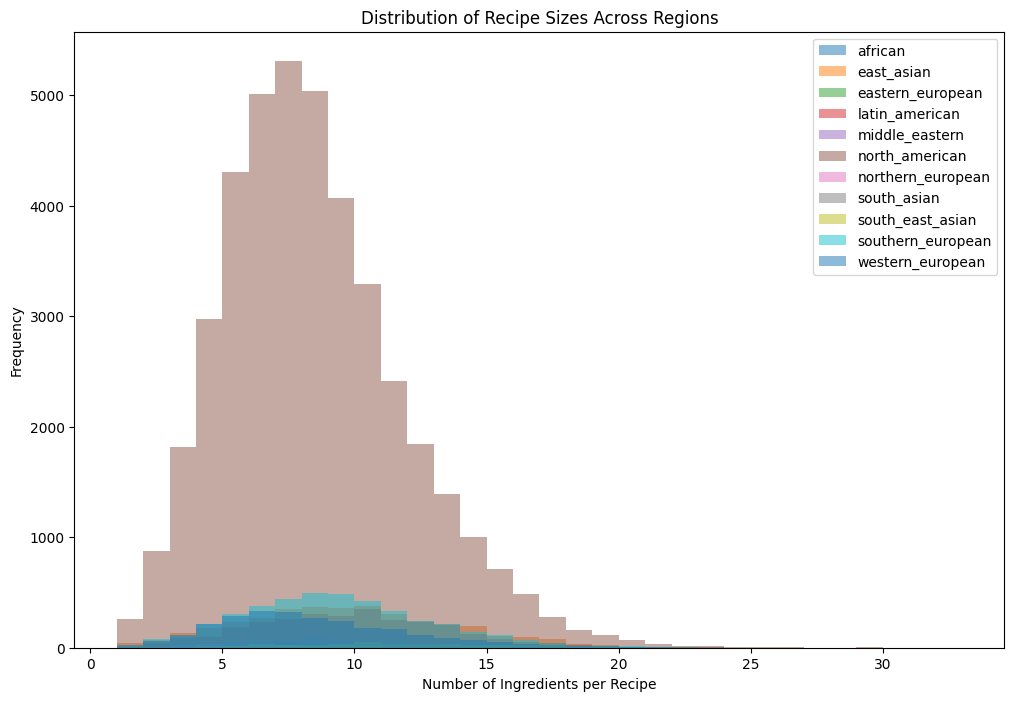

In [704]:
# Drop non-ingredient columns
ingredient_columns = ingredients_df.drop(columns=['region', 'country'])

# Calculate the number of ingredients per recipe (row)
ingredients_df['num_ingredients'] = ingredient_columns.sum(axis=1)

# Step 2: Aggregate data by region
# Group by 'region' and get the distribution of 'num_ingredients'
region_ingredient_counts = ingredients_df.groupby('region')['num_ingredients'].apply(list)

# Step 3: Visualize the distribution
plt.figure(figsize=(12, 8))
for region, counts in region_ingredient_counts.items():
    plt.hist(counts, bins=range(1, max(counts) + 2), alpha=0.5, label=region)

plt.xlabel('Number of Ingredients per Recipe')
plt.ylabel('Frequency')
plt.title('Distribution of Recipe Sizes Across Regions')
plt.legend()
plt.show()

In [705]:
def calculate_max_ingredients_per_region(df):
    max_ingredients_by_region = {}

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        region = row['region']
        num_ingredients = row.drop(['region', 'country']).sum()  # Sum of ingredients for the current row

        # Update max ingredients for the region
        if region not in max_ingredients_by_region:
            max_ingredients_by_region[region] = num_ingredients
        else:
            max_ingredients_by_region[region] = max(max_ingredients_by_region[region], num_ingredients)

    return max_ingredients_by_region

# Calculate maximum number of ingredients per region
max_ingredients_by_region = calculate_max_ingredients_per_region(ingredients_df_with_names)

# Print or display the maximum number of ingredients per region
for region, max_ingredients in max_ingredients_by_region.items():
    print(f"Region: {region}, Max Number of Ingredients: {max_ingredients}")

Region: south_east_asian, Max Number of Ingredients: 24
Region: south_asian, Max Number of Ingredients: 24
Region: southern_european, Max Number of Ingredients: 32
Region: middle_eastern, Max Number of Ingredients: 24
Region: western_european, Max Number of Ingredients: 24
Region: latin_american, Max Number of Ingredients: 25
Region: north_american, Max Number of Ingredients: 30
Region: northern_european, Max Number of Ingredients: 18
Region: african, Max Number of Ingredients: 25
Region: eastern_european, Max Number of Ingredients: 32
Region: east_asian, Max Number of Ingredients: 25


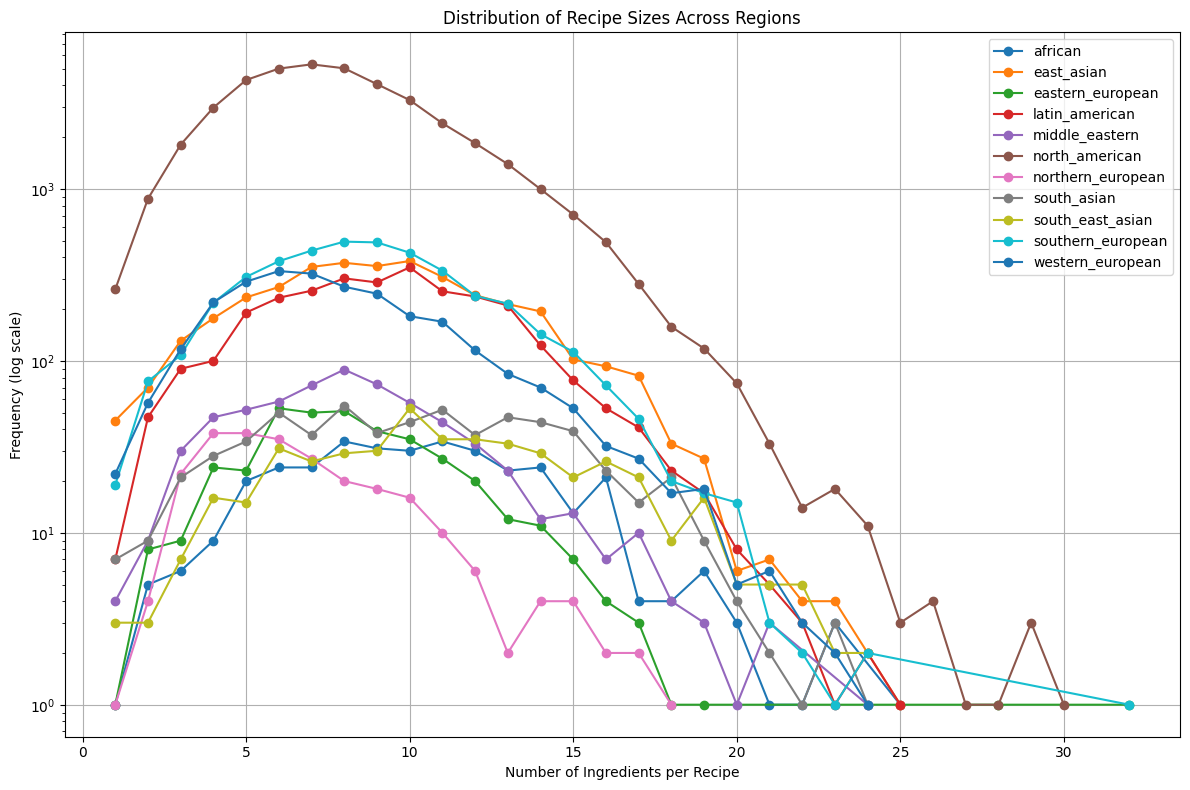

In [706]:
region_ingredient_counts = ingredients_df.groupby('region')['num_ingredients'].apply(list)

# Plotting
plt.figure(figsize=(12, 8))

for region, counts in region_ingredient_counts.items():
    # Check if there are elements in the region, skip plotting if none
    if len(counts) > 0:
        unique_counts, count_frequencies = np.unique(counts, return_counts=True)
        plt.plot(unique_counts, count_frequencies, marker='o', linestyle='-', label=region)

plt.yscale('log')  # Log scale on the y-axis
plt.xticks(np.arange(0, max(ingredients_df['num_ingredients']) + 1, 5))  # Set x ticks every 5 units
plt.xlabel('Number of Ingredients per Recipe')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Recipe Sizes Across Regions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [707]:
ingredients_by_region = ingredients_df_with_names.drop('country', axis=1).groupby('region').sum()



In [708]:
!pip install networkx

"pip" non e riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


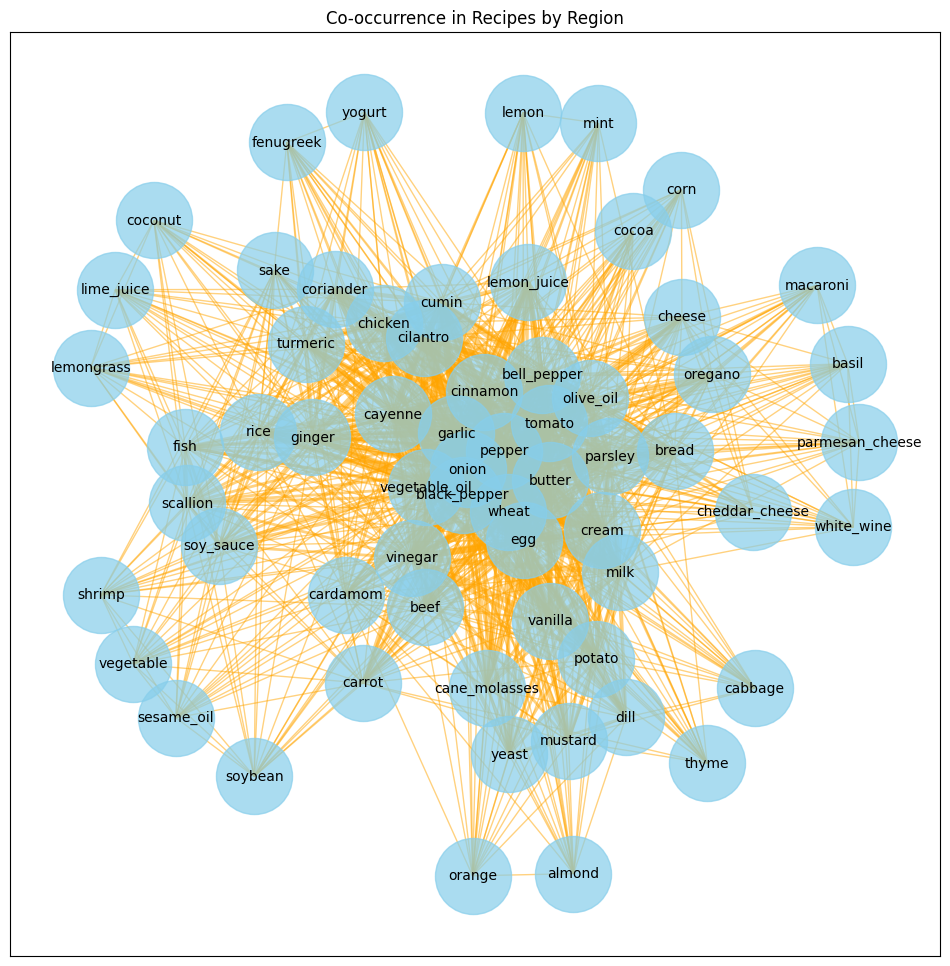

In [709]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assume the dataframe is already loaded as ingredients_df_with_names
# Remove the 'country' column
df = ingredients_df_with_names.drop(columns=['country'])

# Initialize a list to store the top 20 ingredients for each region
top_ingredients_per_region = {}

# Calculate the top 20 ingredients for each region
for region in df['region'].unique():
    region_data = df[df['region'] == region].drop(columns=['region'])
    ingredient_freq = region_data.sum(axis=0)
    top_20_ingredients = ingredient_freq.sort_values(ascending=False).head(20)
    top_ingredients_per_region[region] = top_20_ingredients.index.tolist()

# Create a co-occurrence graph for all regions
G = nx.Graph()

# Add edges based on co-occurrence values for each region
for region, top_ingredients in top_ingredients_per_region.items():
    for i in range(len(top_ingredients)):
        for j in range(i + 1, len(top_ingredients)):
            ingredient1 = top_ingredients[i]
            ingredient2 = top_ingredients[j]
            if G.has_edge(ingredient1, ingredient2):
                G[ingredient1][ingredient2]['weight'] += 1
            else:
                G.add_edge(ingredient1, ingredient2, weight=1)

# Draw the graph
pos = nx.spring_layout(G, k=0.5)  # positions for all nodes

plt.figure(figsize=(12, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue', alpha=0.7)

# Draw edges with widths based on co-occurrence strength
edges = G.edges(data=True)
edge_widths = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=edge_widths, alpha=0.5, edge_color='orange')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title("Co-occurrence in Recipes by Region")
plt.show()


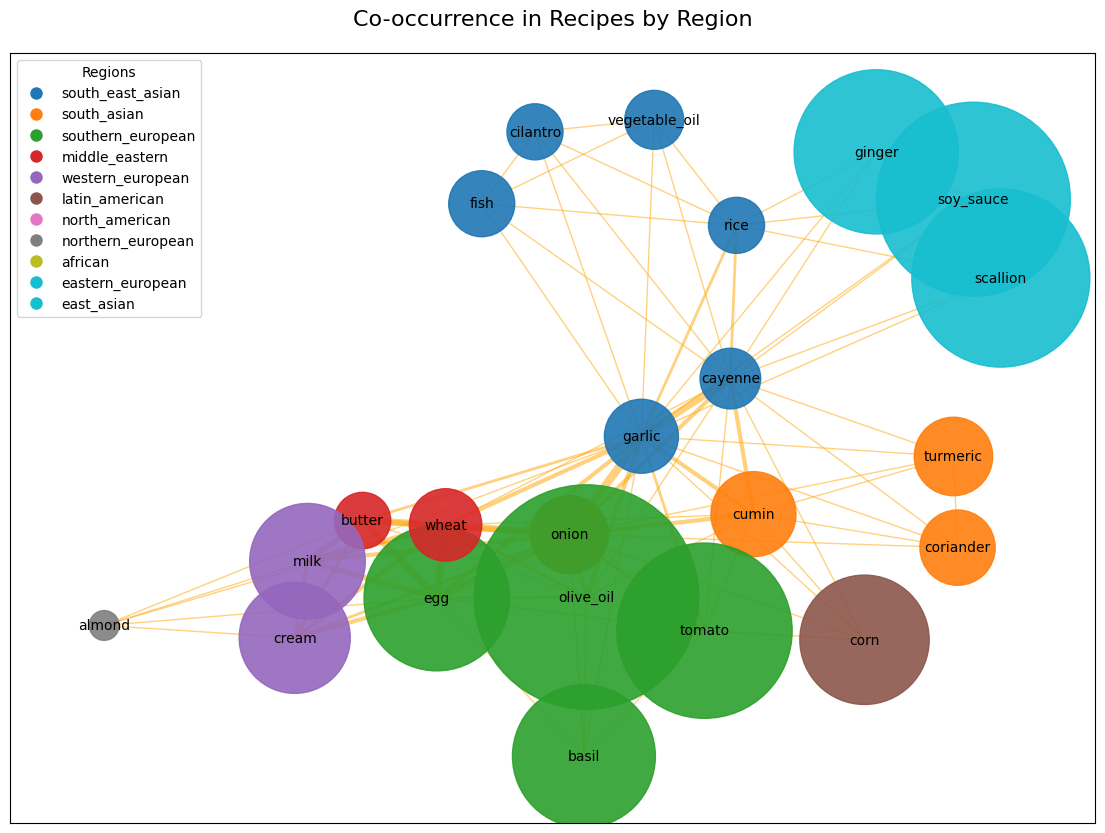

In [710]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Assume the dataframe is already loaded as ingredients_df_with_names
# Remove the 'country' column
df = ingredients_df_with_names.drop(columns=['country'])

# Initialize a list to store the top 6 ingredients for each region
top_ingredients_per_region = {}
ingredient_prevalence = {}

# Calculate the top 6 ingredients for each region
for region in df['region'].unique():
    region_data = df[df['region'] == region].drop(columns=['region'])
    ingredient_freq = region_data.sum(axis=0)
    top_6_ingredients = ingredient_freq.sort_values(ascending=False).head(6)
    top_ingredients_per_region[region] = top_6_ingredients.index.tolist()
    ingredient_prevalence[region] = top_6_ingredients

# Create a co-occurrence graph for all regions
G = nx.Graph()

# Define a color map for regions
colors = plt.cm.tab10(np.linspace(0, 1, len(df['region'].unique())))
region_colors = {region: colors[i] for i, region in enumerate(df['region'].unique())}

# Add nodes and edges with weights and colors based on co-occurrence values for each region
for region, top_ingredients in top_ingredients_per_region.items():
    for ingredient in top_ingredients:
        if ingredient not in G:
            G.add_node(ingredient, size=ingredient_prevalence[region][ingredient], color=region_colors[region])
    
    for i in range(len(top_ingredients)):
        for j in range(i + 1, len(top_ingredients)):
            ingredient1 = top_ingredients[i]
            ingredient2 = top_ingredients[j]
            if G.has_edge(ingredient1, ingredient2):
                G[ingredient1][ingredient2]['weight'] += 1
            else:
                G.add_edge(ingredient1, ingredient2, weight=1)

# Draw the graph
pos = nx.spring_layout(G, k=0.5)  # positions for all nodes

plt.figure(figsize=(14, 10))

# Draw nodes with size based on their prevalence (rescaled for better visualization)
node_sizes = [G.nodes[node]['size'] * 10 for node in G]  # Rescale the size
node_colors = [G.nodes[node]['color'] for node in G]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)

# Draw edges with widths based on co-occurrence strength
edges = G.edges(data=True)
edge_weights = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=edge_weights, alpha=0.5, edge_color='orange')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=region, markersize=10, 
                              markerfacecolor=region_colors[region]) for region in region_colors]
plt.legend(handles=legend_elements, title="Regions", loc="best")

plt.title("Co-occurrence in Recipes by Region", fontsize=16, pad=20)
plt.show()


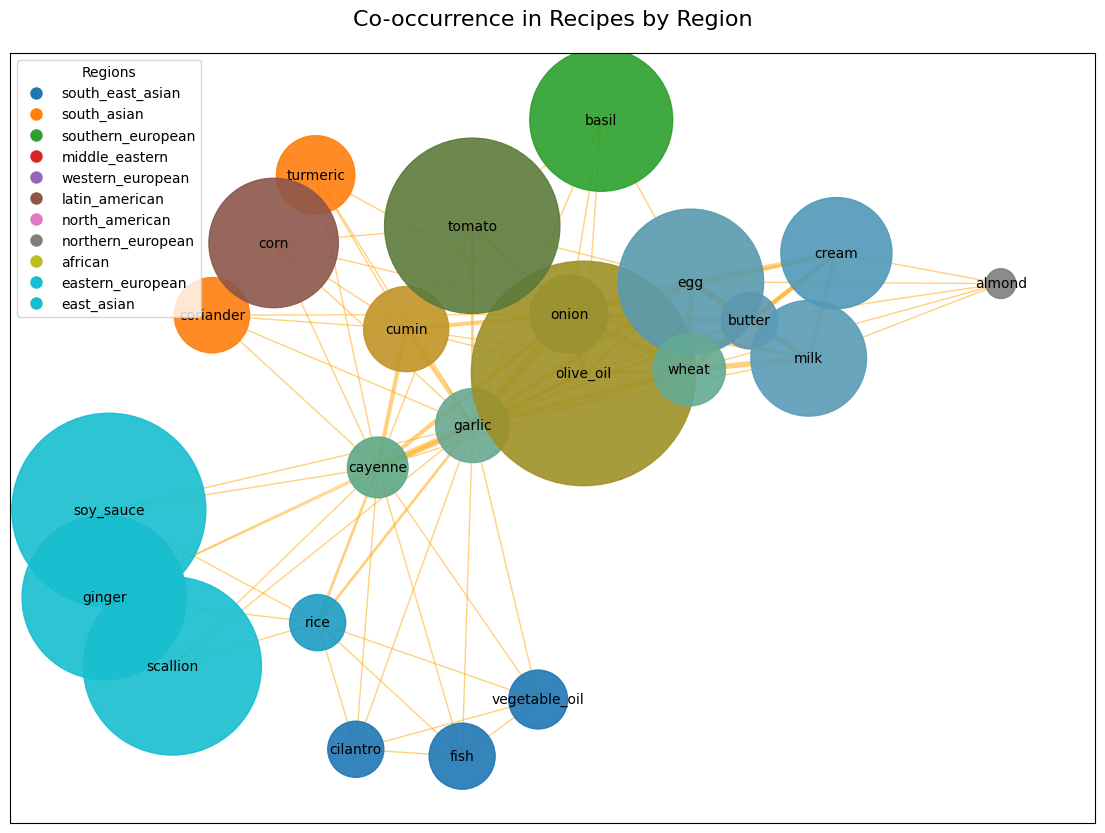

In [711]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


df = ingredients_df_with_names.drop(columns=['country'])

# Initialize a list to store the top 6 ingredients for each region
top_ingredients_per_region = {}
ingredient_prevalence = {}

# Calculate the top 6 ingredients for each region
for region in df['region'].unique():
    region_data = df[df['region'] == region].drop(columns=['region'])
    ingredient_freq = region_data.sum(axis=0)
    top_6_ingredients = ingredient_freq.sort_values(ascending=False).head(6)
    top_ingredients_per_region[region] = top_6_ingredients.index.tolist()
    ingredient_prevalence[region] = top_6_ingredients

# Create a co-occurrence graph for all regions
G = nx.Graph()

# Define a color map for regions
colors = plt.cm.tab10(np.linspace(0, 1, len(df['region'].unique())))
region_colors = {region: colors[i] for i, region in enumerate(df['region'].unique())}

# Add nodes and edges with weights and colors based on co-occurrence values for each region
for region, top_ingredients in top_ingredients_per_region.items():
    for ingredient in top_ingredients:
        if ingredient not in G:
            G.add_node(ingredient, size=ingredient_prevalence[region][ingredient], color=region_colors[region])
        else:
            # Mix colors if ingredient is in multiple regions
            prev_color = G.nodes[ingredient]['color']
            new_color = (prev_color + region_colors[region]) / 2  # Average the colors
            G.nodes[ingredient]['color'] = new_color
    
    for i in range(len(top_ingredients)):
        for j in range(i + 1, len(top_ingredients)):
            ingredient1 = top_ingredients[i]
            ingredient2 = top_ingredients[j]
            if G.has_edge(ingredient1, ingredient2):
                G[ingredient1][ingredient2]['weight'] += 1
            else:
                G.add_edge(ingredient1, ingredient2, weight=1)

# Draw the graph
pos = nx.spring_layout(G, k=0.6)  # Increase k to increase the space between nodes

plt.figure(figsize=(14, 10))

# Draw nodes with size based on their prevalence (rescaled for better visualization)
node_sizes = [G.nodes[node]['size'] * 10 for node in G]  # Rescale the size
node_colors = [G.nodes[node]['color'] for node in G]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)

# Draw edges with widths based on co-occurrence strength
edges = G.edges(data=True)
edge_weights = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=edge_weights, alpha=0.5, edge_color='orange')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=region, markersize=10, 
                              markerfacecolor=region_colors[region]) for region in region_colors]
plt.legend(handles=legend_elements, title="Regions", loc="best")

plt.title("Co-occurrence in Recipes by Region", fontsize=16, pad=20)
plt.show()


c:\Users\cunia\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


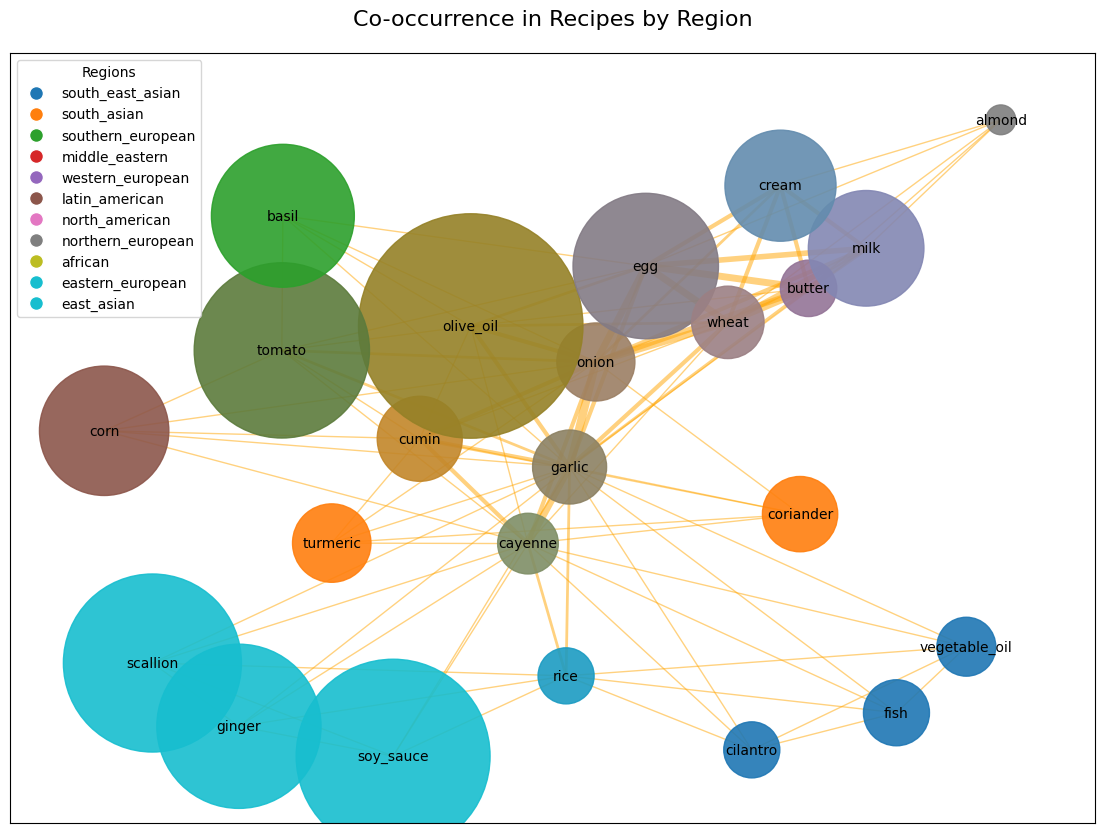

In [712]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Assume the dataframe is already loaded as ingredients_df_with_names
# Remove the 'country' column
df = ingredients_df_with_names.drop(columns=['country'])

# Initialize a list to store the top 6 ingredients for each region
top_ingredients_per_region = {}
ingredient_prevalence = {}

# Calculate the top 6 ingredients for each region
for region in df['region'].unique():
    region_data = df[df['region'] == region].drop(columns=['region'])
    ingredient_freq = region_data.sum(axis=0)
    top_6_ingredients = ingredient_freq.sort_values(ascending=False).head(6)
    top_ingredients_per_region[region] = top_6_ingredients.index.tolist()
    ingredient_prevalence[region] = top_6_ingredients

# Create a co-occurrence graph for all regions
G = nx.Graph()

# Define a color map for regions
region_colors = {region: plt.cm.tab10(i) for i, region in enumerate(df['region'].unique())}

# Add nodes and edges with weights and colors based on co-occurrence values for each region
for region, top_ingredients in top_ingredients_per_region.items():
    for ingredient in top_ingredients:
        if ingredient not in G:
            # Add the ingredient node with size and initial color
            G.add_node(ingredient, size=ingredient_prevalence[region][ingredient], region_colors={region: region_colors[region]})
        else:
            # Add region color information to the ingredient node
            G.nodes[ingredient]['region_colors'][region] = region_colors[region]
    
    for i in range(len(top_ingredients)):
        for j in range(i + 1, len(top_ingredients)):
            ingredient1 = top_ingredients[i]
            ingredient2 = top_ingredients[j]
            if G.has_edge(ingredient1, ingredient2):
                G[ingredient1][ingredient2]['weight'] += 1
            else:
                G.add_edge(ingredient1, ingredient2, weight=1)

# Draw the graph
pos = nx.spring_layout(G, k=0.6)  # Increase k to increase the space between nodes

plt.figure(figsize=(14, 10))

# Draw nodes with size based on their prevalence (rescaled for better visualization)
node_sizes = [G.nodes[node]['size'] * 10 for node in G]  # Rescale the size

# Draw nodes with region colors inside
node_colors = []
for node in G:
    if 'region_colors' in G.nodes[node]:
        colors = list(G.nodes[node]['region_colors'].values())
        avg_color = np.mean(colors, axis=0)
        node_colors.append(avg_color)
    else:
        node_colors.append('white')

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.tab10, alpha=0.9)

# Draw edges with widths based on co-occurrence strength
edges = G.edges(data=True)
edge_weights = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=edge_weights, alpha=0.5, edge_color='orange')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=region, markersize=10, 
                              markerfacecolor=color) for region, color in region_colors.items()]
plt.legend(handles=legend_elements, title="Regions", loc="best")

plt.title("Co-occurrence in Recipes by Region", fontsize=16, pad=20)
plt.show()




In [713]:
ingredients_by_region.head(3)

,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,artichoke,...,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
region,,,,,,,,,,,,,,,,,,,,,
african,44,0,2,1,6,0,23,0,0,1,...,0,2,12,4,4,0,2,9,7,25
east_asian,34,0,1,7,34,0,10,0,12,0,...,1,3,76,3,299,0,2,46,16,18
eastern_european,15,0,2,0,18,0,18,0,0,0,...,4,5,16,1,1,0,0,48,6,1


In [714]:
!pip install fpdf


"pip" non e riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [715]:
"""from fpdf import FPDF
def calculate_min_max_counts(df):
    # Initialize dictionaries to store min and max counts
    min_counts = {}
    max_counts = {}

    # Initialize dictionary to store ingredients with value 1 for each region
    ingredients_with_1 = {}

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        region = row['region']
        # Calculate counts of '1' for each ingredient in the current row
        counts = {col: value for col, value in row.items() if value == 1 and col not in ['region', 'country']}
        
        # Update min and max counts for the region
        if region not in min_counts:
            min_counts[region] = len(counts)
            max_counts[region] = len(counts)
            ingredients_with_1[region] = counts
        else:
            min_counts[region] = min(min_counts[region], len(counts))
            max_counts[region] = max(max_counts[region], len(counts))
            ingredients_with_1[region].update(counts)

    return min_counts, max_counts, ingredients_with_1

# Calculate min and max counts of '1' and collect ingredients for each region
min_counts, max_counts, ingredients_with_1 = calculate_min_max_counts(ingredients_df_with_names)

# Create a PDF
pdf = FPDF()
pdf.add_page()

# Set font
pdf.set_font("Arial", size=12)

# Group ingredients by region and sum them up
ingredients_by_region = ingredients_df_with_names.drop('country', axis=1).groupby('region').sum()

# Iterate over the dataframe to write information into the PDF
for region, row in ingredients_by_region.iterrows():
    # Add region title
    pdf.cell(200, 10, f"Region: {region}", ln=True)

    # Prepare a single string with non-zero ingredients for the region
    ingredients_list = ', '.join([f"{ingredient}" for ingredient, value in row.items() if value != 0])

    # Write the ingredients list using MultiCell for automatic wrapping
    pdf.multi_cell(200, 10, f"Ingredients: {ingredients_list}")

    # Add min and max counts of '1' for the region
    pdf.cell(200, 10, f"Min Ingredients : {min_counts.get(region, 0)}", ln=True)
    pdf.cell(200, 10, f"Max Ingredients : {max_counts.get(region, 0)}", ln=True)

    pdf.cell(200, 10, "", ln=True)  # Empty space

# Save the PDF
pdf_file = "ingredients_by_region_with_min_max.pdf"
pdf.output(pdf_file)

print(f"PDF created successfully: {pdf_file}")"""

'from fpdf import FPDF\ndef calculate_min_max_counts(df):\n    # Initialize dictionaries to store min and max counts\n    min_counts = {}\n    max_counts = {}\n\n    # Initialize dictionary to store ingredients with value 1 for each region\n    ingredients_with_1 = {}\n\n    # Iterate over each row in the DataFrame\n    for index, row in df.iterrows():\n        region = row[\'region\']\n        # Calculate counts of \'1\' for each ingredient in the current row\n        counts = {col: value for col, value in row.items() if value == 1 and col not in [\'region\', \'country\']}\n        \n        # Update min and max counts for the region\n        if region not in min_counts:\n            min_counts[region] = len(counts)\n            max_counts[region] = len(counts)\n            ingredients_with_1[region] = counts\n        else:\n            min_counts[region] = min(min_counts[region], len(counts))\n            max_counts[region] = max(max_counts[region], len(counts))\n            ingredie

In [716]:
"""from fpdf import FPDF

def calculate_min_max_counts(df):
    # Initialize dictionaries to store min and max counts
    min_counts = {}
    max_counts = {}

    # Initialize dictionary to store ingredients with value 1 for each region
    ingredients_with_1 = {}

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        region = row['region']
        # Calculate counts of '1' for each ingredient in the current row
        counts = {col: value for col, value in row.items() if value == 1 and col not in ['region', 'country']}
        
        # Update min and max counts for the region
        if region not in min_counts:
            min_counts[region] = len(counts)
            max_counts[region] = len(counts)
            ingredients_with_1[region] = counts
        else:
            min_counts[region] = min(min_counts[region], len(counts))
            max_counts[region] = max(max_counts[region], len(counts))
            ingredients_with_1[region].update(counts)

    return min_counts, max_counts, ingredients_with_1

# Calculate min and max counts of '1' and collect ingredients for each region
min_counts, max_counts, ingredients_with_1 = calculate_min_max_counts(ingredients_df_with_names)

# Group ingredients by region and sum them up
ingredients_by_region = ingredients_df_with_names.drop('country', axis=1).groupby('region').sum()

# Iterate over the dataframe to create a separate PDF for each region
for region, row in ingredients_by_region.iterrows():
    # Initialize PDF for the current region
    pdf = FPDF()
    pdf.add_page()

    # Set font
    pdf.set_font("Arial", size=12)

    # Add region title
    pdf.cell(200, 10, f"Region: {region}", ln=True)

    # Prepare a single string with non-zero ingredients for the region
    ingredients_list = ', '.join([f"{ingredient}" for ingredient, value in row.items() if value != 0])

    # Write the ingredients list using MultiCell for automatic wrapping
    pdf.multi_cell(200, 10, f"Ingredients: {ingredients_list}")

    # Add min and max counts of '1' for the region
    pdf.cell(200, 10, f"Min Ingredients : {min_counts.get(region, 0)}", ln=True)
    pdf.cell(200, 10, f"Max Ingredients : {max_counts.get(region, 0)}", ln=True)

    pdf.cell(200, 10, "", ln=True)  # Empty space

    # Save the PDF for the current region
    pdf_file = f"{region}_ingredients_by_region_with_min_max.pdf"
    pdf.output(pdf_file)

    print(f"PDF created successfully: {pdf_file}")"""


'from fpdf import FPDF\n\ndef calculate_min_max_counts(df):\n    # Initialize dictionaries to store min and max counts\n    min_counts = {}\n    max_counts = {}\n\n    # Initialize dictionary to store ingredients with value 1 for each region\n    ingredients_with_1 = {}\n\n    # Iterate over each row in the DataFrame\n    for index, row in df.iterrows():\n        region = row[\'region\']\n        # Calculate counts of \'1\' for each ingredient in the current row\n        counts = {col: value for col, value in row.items() if value == 1 and col not in [\'region\', \'country\']}\n        \n        # Update min and max counts for the region\n        if region not in min_counts:\n            min_counts[region] = len(counts)\n            max_counts[region] = len(counts)\n            ingredients_with_1[region] = counts\n        else:\n            min_counts[region] = min(min_counts[region], len(counts))\n            max_counts[region] = max(max_counts[region], len(counts))\n            ingred

In [717]:
from fpdf import FPDF

def calculate_min_max_counts(df):
    # Initialize dictionaries to store min and max counts
    min_counts = {}
    max_counts = {}

    # Initialize dictionary to store ingredients with value 1 for each region
    ingredients_with_1 = {}

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        region = row['region']
        # Calculate counts of '1' for each ingredient in the current row
        counts = {col: value for col, value in row.items() if value == 1 and col not in ['region', 'country']}
        
        # Update min and max counts for the region
        if region not in min_counts:
            min_counts[region] = len(counts)
            max_counts[region] = len(counts)
            ingredients_with_1[region] = counts
        else:
            min_counts[region] = min(min_counts[region], len(counts))
            max_counts[region] = max(max_counts[region], len(counts))
            ingredients_with_1[region].update(counts)

    return min_counts, max_counts, ingredients_with_1

# Calculate min and max counts of '1' and collect ingredients for each region
min_counts, max_counts, ingredients_with_1 = calculate_min_max_counts(ingredients_df_with_names)

# Group ingredients by region and sum them up
ingredients_by_region = ingredients_df_with_names.drop('country', axis=1).groupby('region').sum()

# Iterate over the dataframe to create a separate PDF for each region
for region, row in ingredients_by_region.iterrows():
    # Initialize PDF for the current region
    pdf = FPDF()
    pdf.add_page()

    # Set font
    pdf.set_font("Arial", size=12)

    # Add cousine title instead of region
    pdf.cell(200, 10, f"Cousine: {region}", ln=True)

    # Prepare a single string with non-zero ingredients for the region
    ingredients_list = ', '.join([f"{ingredient}" for ingredient, value in row.items() if value != 0])

    # Write the ingredients list using MultiCell for automatic wrapping
    pdf.multi_cell(200, 10, f"Ingredients: {ingredients_list}")

    # Add min and max counts of '1' for the region
    pdf.cell(200, 10, f"Min Ingredients : {min_counts.get(region, 0)}", ln=True)
    pdf.cell(200, 10, f"Max Ingredients : {max_counts.get(region, 0)}", ln=True)

    pdf.cell(200, 10, "", ln=True)  # Empty space

    # Save the PDF for the current region with cousine name
    pdf_file = f"{region}_ingredients_by_cousine_with_min_max.pdf"
    pdf.output(pdf_file)

    print(f"PDF created successfully: {pdf_file}")


PDF created successfully: african_ingredients_by_cousine_with_min_max.pdf
PDF created successfully: east_asian_ingredients_by_cousine_with_min_max.pdf
PDF created successfully: eastern_european_ingredients_by_cousine_with_min_max.pdf
PDF created successfully: latin_american_ingredients_by_cousine_with_min_max.pdf
PDF created successfully: middle_eastern_ingredients_by_cousine_with_min_max.pdf
PDF created successfully: north_american_ingredients_by_cousine_with_min_max.pdf
PDF created successfully: northern_european_ingredients_by_cousine_with_min_max.pdf
PDF created successfully: south_asian_ingredients_by_cousine_with_min_max.pdf
PDF created successfully: south_east_asian_ingredients_by_cousine_with_min_max.pdf
PDF created successfully: southern_european_ingredients_by_cousine_with_min_max.pdf
PDF created successfully: western_european_ingredients_by_cousine_with_min_max.pdf


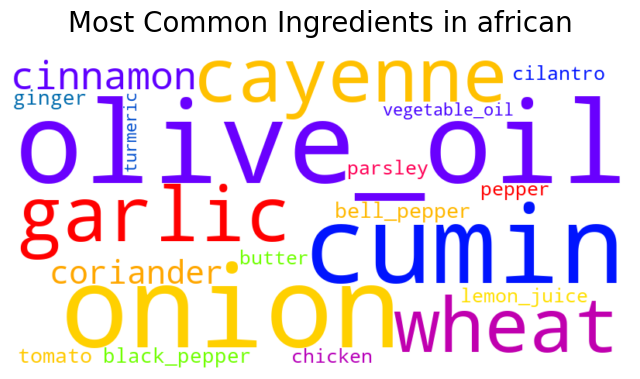

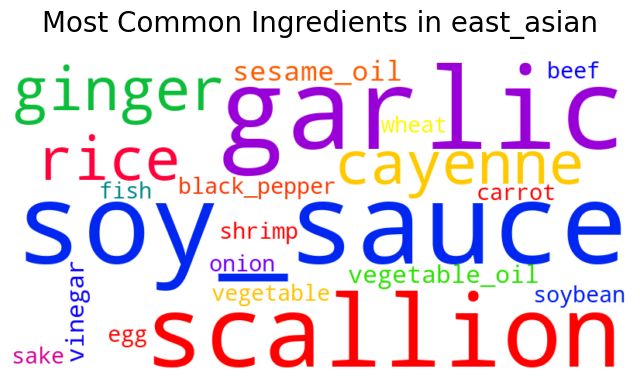

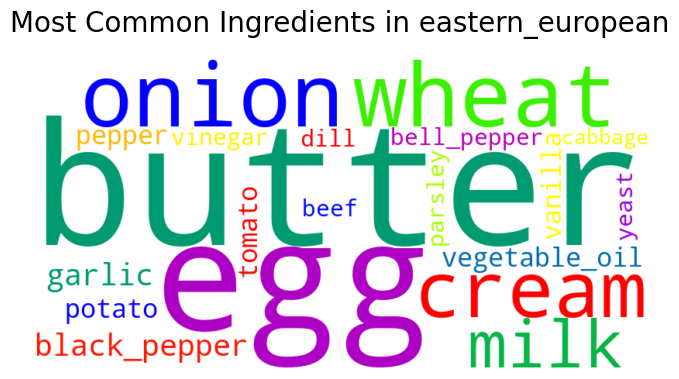

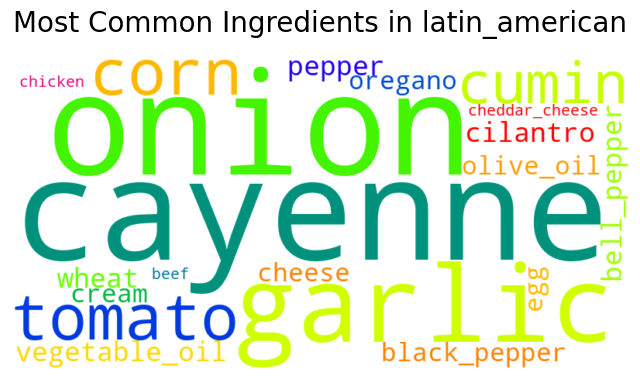

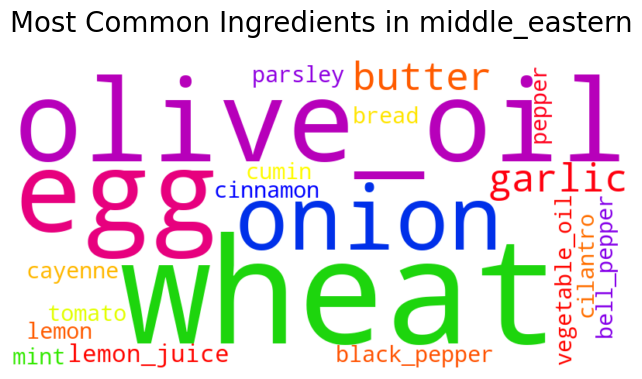

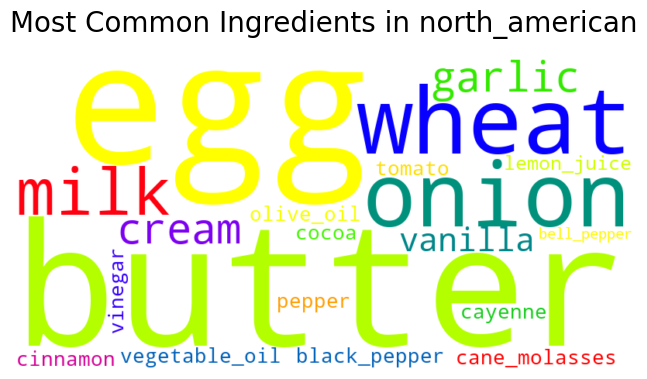

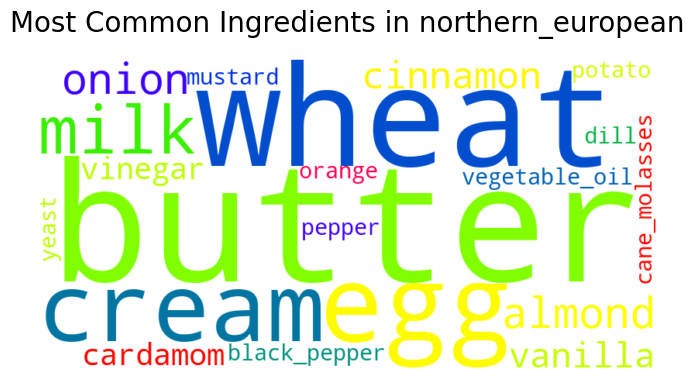

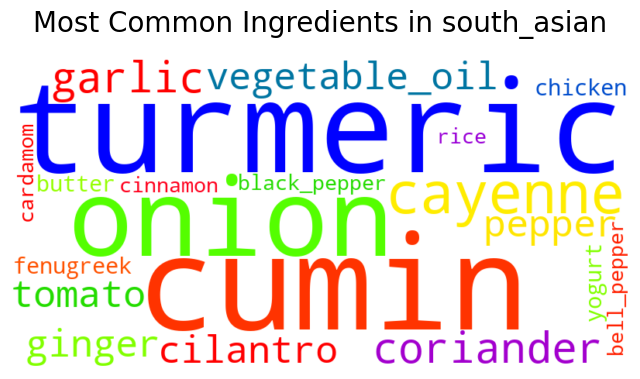

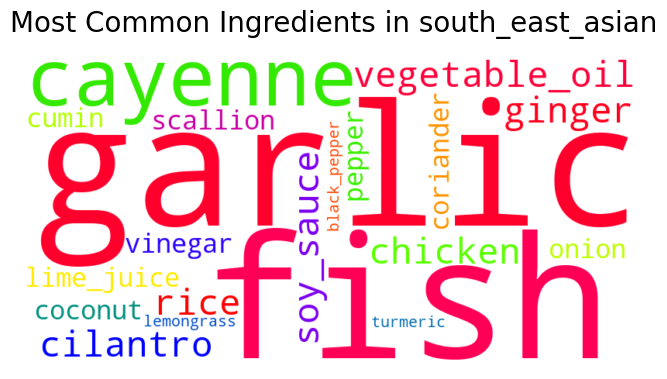

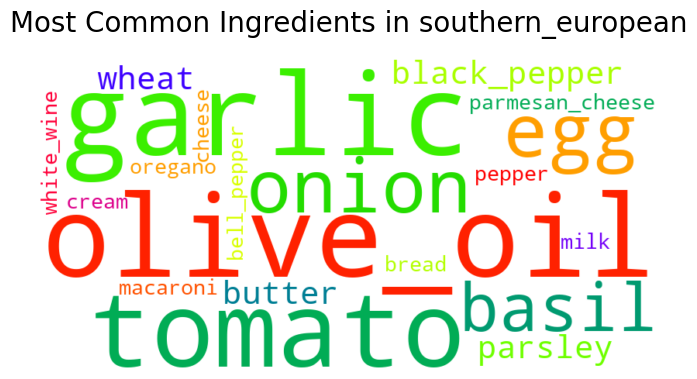

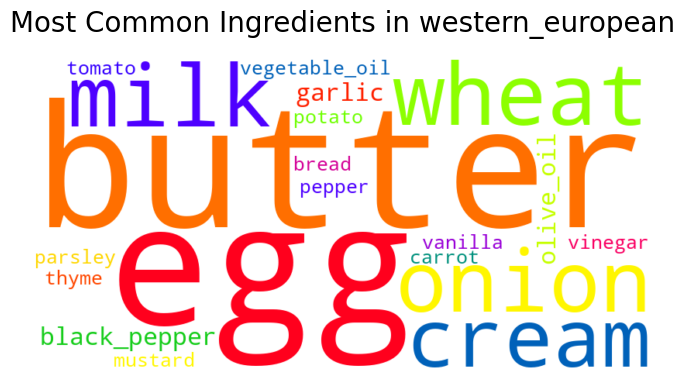

In [718]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


def generate_wordcloud_for_region(region_data):
    # Extract the region name
    region_name = region_data.index[0]  # Get the region name from the index
    
    # Filtra il DataFrame per la regione specificata (escludendo la colonna 'country')
    ingredients_used = region_data.drop(columns=['country'])
    
    # Calcola la frequenza degli ingredienti
    ingredient_freq = ingredients_used.sum(axis=0)
    
    # Seleziona i primi 20 ingredienti più comuni
    top_ingredients = ingredient_freq.sort_values(ascending=False).head(20)
    
    # Normalizza gli ingredienti (esempio: rimuovi stop words)
    stop_words = set(ENGLISH_STOP_WORDS)  # Use English stop words as an example
    normalized_ingredients = ' '.join([ingredient for ingredient in top_ingredients.index if ingredient not in stop_words])
    
    # Crea la WordCloud per gli ingredienti nella regione specificata
    plt.figure(figsize=(8, 8))
    wordcloud = WordCloud(
        background_color='white',
        width=800,
        height=400,
        colormap='prism'
    ).generate(normalized_ingredients)
    
    # Mostra la WordCloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Common Ingredients in {region_name}',fontsize=20, pad=20)
    plt.axis('off')  # Disable x and y axes
    plt.show()

# Set the 'region' column as index
ingredients_df_with_names.set_index('region', inplace=True)

# Raggruppa per regione e genera le WordCloud per ciascun gruppo
for region, region_data in ingredients_df_with_names.groupby(level=0):
    generate_wordcloud_for_region(region_data)


In [719]:
comp_df['compound_name'] = comp_df['compound_name'].astype(str)

In [720]:
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   compound_id    1107 non-null   int64 
 1   compound_name  1107 non-null   object
 2   CAS_number     1107 non-null   object
dtypes: int64(1), object(2)
memory usage: 26.1+ KB


In [721]:
sparse_matrix

NameError: name 'sparse_matrix' is not defined

In [ ]:
# Convert to dense vectors
dense_vectors = sparse_matrix.todense()

# Create a DataFrame for easy handling
dense_df = pd.DataFrame(dense_vectors)

In [ ]:
# Function to get vectors from the dense matrix
def get_ingredient_vectors(dense_matrix):
    ingredient_vectors = dense_matrix.values  # Convert DataFrame to numpy array
    return ingredient_vectors

# Get ingredient vectors
ingredient_vectors = get_ingredient_vectors(dense_df)

ValueError: Expected a 1D array, got an array with shape (1525, 1107)

In [ ]:
dense_df

,0,1,2,3,4,5,6,7,8,9,...,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dense_df.T

,0,1,2,3,4,5,6,7,8,9,...,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mother_matrix = dense_df.dot(dense_df.T)

In [ ]:
mother_matrix = mother_matrix.astype(int)

In [ ]:
mother_matrix

,0,1,2,3,4,5,6,7,8,9,...,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,41,1,0,29,1,0,...,1,0,0,0,28,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
1521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1523,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,2,0,0,0,3,0


In [ ]:
dense_df.dot(query_vector)

0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1520    0.0
1521    0.0
1522    0.0
1523    0.0
1524    0.0
Length: 1525, dtype: float64

In [ ]:
ingredients_df.to_csv('data/ingredients_df.csv', index=False)

In [ ]:
# Function to get column names where the row has 1s
def get_ingredients(row):
    return [re.findall(r'\d+', col)[0] for col in ingredients_df.columns if row[col] == 1]

# Apply the function to each row
ingredients_df['ingredient_list'] = ingredients_df.apply(get_ingredients, axis=1)

In [ ]:
print(ingredients_df['ingredient_list'])

0        [256, 1216, 663, 658, 1044, 878, 136, 141, 243...
1                            [7, 663, 878, 136, 1447, 165]
2                                    [136, 243, 1183, 406]
3        [256, 1348, 512, 663, 658, 878, 164, 1199, 243...
4        [663, 1267, 1044, 878, 136, 1132, 243, 166, 11...
                               ...                        
57686    [698, 724, 1117, 1044, 848, 396, 1140, 1447, 2...
57687                [1338, 848, 221, 417, 915, 1336, 127]
57688    [1281, 427, 878, 136, 164, 1471, 205, 455, 130...
57689                     [19, 1237, 848, 164, 1012, 1179]
57690    [1281, 848, 396, 1447, 1471, 205, 1412, 1183, ...
Name: ingredient_list, Length: 57691, dtype: object


In [ ]:
ingredients_df.head()

,region,country,ingr_18,ingr_725,ingr_707,ingr_395,ingr_1197,ingr_761,ingr_1120,ingr_190,...,ingr_703,ingr_1428,ingr_1278,ingr_84,ingr_1396,ingr_705,ingr_407,ingr_230,ingr_1080,ingredient_list
0,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[256, 1216, 663, 658, 1044, 878, 136, 141, 243..."
1,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[7, 663, 878, 136, 1447, 165]"
2,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[136, 243, 1183, 406]"
3,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[256, 1348, 512, 663, 658, 878, 164, 1199, 243..."
4,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[663, 1267, 1044, 878, 136, 1132, 243, 166, 11..."


In [ ]:
ingredients_slised =ingredients_df[['country', 'region', 'ingredient_list']].copy()

In [ ]:
ingredients_slised.head()

,country,region,ingredient_list
0,vietnamese,south_east_asian,"[256, 1216, 663, 658, 1044, 878, 136, 141, 243..."
1,vietnamese,south_east_asian,"[7, 663, 878, 136, 1447, 165]"
2,vietnamese,south_east_asian,"[136, 243, 1183, 406]"
3,vietnamese,south_east_asian,"[256, 1348, 512, 663, 658, 878, 164, 1199, 243..."
4,vietnamese,south_east_asian,"[663, 1267, 1044, 878, 136, 1132, 243, 166, 11..."


In [ ]:
comp_per_ingr

,ingredient_id,compound_id
0,0,[995]
1,1,[921]
2,10,[715]
3,100,[1011]
4,1000,"[764, 275, 630, 1046, 285, 84, 482, 772, 686, ..."
...,...,...
1520,995,[996]
1521,996,[894]
1522,997,[828]
1523,998,"[25, 317, 86]"


In [ ]:
#Function to get compound list for each ingredient in the ingredient list
def add_compound_to_recipe(row):
    compound_list = []
    for ingredient in row['ingredient_list']:
        compounds = comp_per_ingr.loc[comp_per_ingr['ingredient_id'] == ingredient, 'compound_id']
        if not compounds.empty:
            compound_list.extend(compounds.values[0])
    return compound_list

# Apply the function to each row
ingredients_slised['compound_list'] = ingredients_slised.apply(add_compound_to_recipe, axis=1)

In [ ]:
ingredients_slised

,country,region,ingredient_list,compound_list
0,vietnamese,south_east_asian,"[256, 1216, 663, 658, 1044, 878, 136, 141, 243...","[347, 847, 700, 75, 278, 767, 283, 295, 442, 7..."
1,vietnamese,south_east_asian,"[7, 663, 878, 136, 1447, 165]","[273, 971, 348, 628, 767, 704, 79, 965, 361, 4..."
2,vietnamese,south_east_asian,"[136, 243, 1183, 406]","[273, 827, 388, 175, 798, 392, 599, 1035, 429,..."
3,vietnamese,south_east_asian,"[256, 1348, 512, 663, 658, 878, 164, 1199, 243...","[347, 847, 700, 75, 278, 767, 283, 295, 442, 7..."
4,vietnamese,south_east_asian,"[663, 1267, 1044, 878, 136, 1132, 243, 166, 11...","[273, 971, 348, 628, 767, 704, 620, 79, 965, 3..."
...,...,...,...,...
57686,japanese,east_asian,"[698, 724, 1117, 1044, 848, 396, 1140, 1447, 2...","[558, 423, 766, 282, 426, 1035, 633, 976, 96, ..."
57687,japanese,east_asian,"[1338, 848, 221, 417, 915, 1336, 127]","[272, 965, 827, 275, 424, 400, 704, 427, 284, ..."
57688,japanese,east_asian,"[1281, 427, 878, 136, 164, 1471, 205, 455, 130...","[772, 526, 157, 72, 423, 195, 1025, 282, 990, ..."
57689,japanese,east_asian,"[19, 1237, 848, 164, 1012, 1179]","[272, 275, 284, 285, 568, 292, 837, 841, 1, 19..."


In [ ]:
ingredients_df.head()

,region,country,ingr_18,ingr_725,ingr_707,ingr_395,ingr_1197,ingr_761,ingr_1120,ingr_190,...,ingr_703,ingr_1428,ingr_1278,ingr_84,ingr_1396,ingr_705,ingr_407,ingr_230,ingr_1080,ingredient_list
0,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[256, 1216, 663, 658, 1044, 878, 136, 141, 243, 166, 998, 205, 165, 249, 694, 1012]"
1,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[7, 663, 878, 136, 1447, 165]"
2,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[136, 243, 1183, 406]"
3,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[256, 1348, 512, 663, 658, 878, 164, 1199, 243, 166, 1088, 205, 258, 1305, 1113]"
4,south_east_asian,vietnamese,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[663, 1267, 1044, 878, 136, 1132, 243, 166, 1160, 205, 915, 694, 1012]"
